# TrainBN

In [1]:
using AutomotiveDrivingModels
using DynamicBayesianNetworkBehaviors

## Parameters

In [2]:
include(Pkg.dir("AutomotiveDrivingModels", "scripts", "extract_params.jl"))
nothing

In [3]:
dset_filepath_modifier = "_following" # _freeflow, _following, _lanechange

"_following"

In [4]:
dset = JLD.load(joinpath(EVALUATION_DIR, "dataset2" * dset_filepath_modifier * ".jld"),
                "model_training_data")::ModelTrainingData2
runlogs_original = load_runlogs(dset)
streetnets = load_streetnets(runlogs_original)

fold = 1
cv_split_outer = get_fold_assignment_across_drives(dset, N_FOLDS)
cv_split_inner = drop_fold!(deepcopy(cv_split_outer), fold)
@assert(cv_split_inner.nfolds > 0)

nframes = nrow(dset.dataframe)
ntraces = length(cv_split_outer.seg_assignment);

## Optimize Hyperparams

In [5]:
train_def = BehaviorTrainDefinition(
                                    BN_TrainParams(
                                        indicators=INDICATOR_SET2,
                                        preoptimize_target_bins=true,
                                        preoptimize_indicator_bins=true,
                                        optimize_structure=true,
                                        optimize_target_bins=false,
                                        optimize_parent_bins=false,
                                        ncandidate_bins=20,
                                    ),
                                    [
                                        BehaviorParameter(:max_parents, 3:7, 2),
                                        BehaviorParameter(:dirichlet_prior, [UniformPrior(), BDeuPrior(0.5), BDeuPrior(1.0), BDeuPrior(2.0), BDeuPrior(10.0)], 1),
                                    ])

preallocated_data = preallocate_learning_data(dset, train_def.trainparams)
print(train_def); sleep(0.1)

BehaviorTrainDefinition
BN Train Params
starting_structure
	lat: AutomotiveDrivingModels.Features.AbstractFeature[]
	lon: AutomotiveDrivingModels.Features.AbstractFeature[]
forced
	lat: AutomotiveDrivingModels.Features.AbstractFeature[]
	lon: AutomotiveDrivingModels.Features.AbstractFeature[]
targets
	lat: f_des_angle
	lon: f_accel
prior:           UniformPrior
verbosity:       0
ncandidate_bins: 20
max_parents:     6
nbins_lat:       7
nbins_lon:       7
preoptimize_target_bins:    true
preoptimize_indicator_bins: true
optimize_structure:         true
optimize_target_bins:       false
optimize_parent_bins:       false

hyperparams:
	max_parents:         [3, >4<, 5, 6, 7]
	dirichlet_prior:     [>UniformPrior<, BDeuPrior(0.50), BDeuPrior(1.00), BDeuPrior(2.00), BDeuPrior(10.00)]


In [6]:
AutomotiveDrivingModels.optimize_hyperparams_cyclic_coordinate_ascent!(
                    train_def, dset, preallocated_data, cv_split_inner)
print(train_def); sleep(0.1)

                                       λ   i   logl  logl*
optimize_hyperparams_cyclic_coordinate_ascent iteration 1  et: 0.0005970001220703125
                             max_parents   1 3.5093   -Inf
                             max_parents   2 3.5093 3.5093
                             max_parents   3 3.5093 3.5093
                             max_parents   4 3.5093 3.5093
                             max_parents   5 3.5093 3.5093
                         dirichlet_prior   2 3.5071 3.5093
                         dirichlet_prior   3 3.5069 3.5093
                         dirichlet_prior   4 3.5053 3.5093
                         dirichlet_prior   5 3.5053 3.5093
optimize_hyperparams_cyclic_coordinate_ascent iteration 2  et: 65.21424412727356
                             max_parents   1 3.5093 3.5093
                             max_parents   2 3.5093 3.5093
                             max_parents   3 3.5093 3.5093
                             max_parents   4 3.5093 3.5093
Behavior

## Train

In [7]:
BN = train(dset, preallocated_data, train_def.trainparams, fold, cv_split_outer, true);
print(BN)

DynamicBayesianNetworkBehavior
	DBNModel: 
DBNModel
	f_accel <- [:acc,:has_lane_left]
	f_des_angle <- [:velFt]
	ind_lat:          2
	ind_lon:          1
	symbol_lat:       f_accel
	symbol_lon:       f_des_angle
	ordering:         [5,4,3,2,1]
	subset_extractor: AutomotiveDrivingModels.FeaturesNew.FeatureSubsetExtractor([3.5e-323,2.5e-323,1.0e-323],AutomotiveDrivingModels.FeaturesNew.AbstractFeature[AutomotiveDrivingModels.FeaturesNew.Feature_VelFt(),AutomotiveDrivingModels.FeaturesNew.Feature_Acc(),AutomotiveDrivingModels.FeaturesNew.Feature_Has_Lane_Left()])
	action_clamper:   AutomotiveDrivingModels.FeaturesNew.DataClamper([

## Likelihood

In [8]:
arr_logl_train = Float64[]
arr_logl_test = Float64[]
for frameind in 1 : nframes
    if trains_with_nona(BN)
        logl = calc_action_loglikelihood(BN, dset.dataframe_nona, frameind)
    else
        logl = calc_action_loglikelihood(BN, dset.dataframe, frameind)
    end
    
    if is_in_fold(fold, cv_split_outer.frame_assignment[frameind], true)
        push!(arr_logl_test, logl)
    else
        push!(arr_logl_train, logl)
    end
end

println("extrema train: ", extrema(arr_logl_train))
println("extrema test:  ", extrema(arr_logl_test))

3.5e-323,6.9436796581701e-310],[-0.5586391289139377,-3.3573211206085176],[0.43804364359439696,3.3280399188834835])
extrema train: (-13.753873803342913,5.1994200006398)
extrema test:  (-4.367054910620171,5.1994200006398)


    .>(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:179
is ambiguous with: 
    .>(AbstractArray{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:330.
To fix, define 
    .>(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}})
before the new definition.
    .>(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:179
is ambiguous with: 
    .>(AbstractArray, Union{DataArrays.DataArray, DataArrays.PooledDataArray}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:285.
To fix, define 
    .>(Images.AbstractImageDirect, Union{DataArrays.DataArray, DataArrays.PooledDataArray})
before the new definition.
    .*(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:

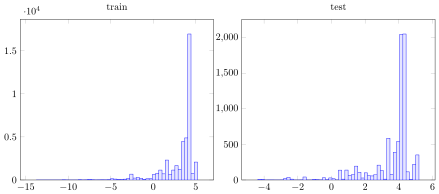

In [9]:
using PGFPlots
g = GroupPlot(2,1)
push!(g, Axis(Plots.Histogram(arr_logl_train, bins=50), ymin=0, title="train"))
push!(g, Axis(Plots.Histogram(arr_logl_test, bins=50), ymin=0, title="test"))
g

## Why is BN turning off-course?